In [179]:
import math
import numpy as np
import cv2
import matplotlib.pyplot as plt
def calculate_psnr(img1, img2):
    res=1e-10
    # img1 and img2 have range [0, 255]
    img1 = img1.astype(np.float64)
    img2 = img2.astype(np.float64)
    mse = np.mean((img1 - img2)**2)
    if mse == 0:
        res= float('inf')
   
    else:
        res= 20 * math.log10(255.0 / math.sqrt(mse))

    print('The PSNR score is '+ str(res))
    

In [3]:
import random
def genrandomColor():
    a=random.randint(0,255)
    b=random.randint(0,255)
    c=random.randint(0,255)

    return(a,b,c)

#draw line on img1 
def drawlines(img1,img2,lines,pts1,pts2):
    r,c = img1.shape

    for r,pt1,pt2 in zip(lines,pts1,pts2):
        color = genrandomColor()
        x0,y0 = map(int, [0, -r[2]/r[1] ])
        x1,y1 = map(int, [c, -(r[2]+r[0]*c)/r[1] ])
        img1 = cv2.line(img1, (x0,y0), (x1,y1), color,1)
        img1 = cv2.circle(img1,tuple(pt1),3,color,-1)
        img2 = cv2.circle(img2,tuple(pt2),3,color,-1)
    return img1,img2

In [4]:
#feature extraction through SIFT
def Sift_extract(l,r):
    sift=cv2.SIFT_create()
    kpLeft,desLeft=sift.detectAndCompute(l,None)
    kpRight,desRight=sift.detectAndCompute(r,None)


    flann=cv2.FlannBasedMatcher(dict(algorithm=1,tree=5),dict(checks=50))
    matches = flann.knnMatch(desLeft,desRight,k=2)

    # Apply ratio test for selecting good pts
    
    good_pts_left=[]
    good_pts_right=[]
    for m,n in matches:
        if m.distance < 0.75*n.distance:
           
            good_pts_left.append(kpLeft[m.queryIdx].pt)
            good_pts_right.append(kpRight[m.trainIdx].pt)


    good_pts_left=np.array(good_pts_left)
    good_pts_right=np.array(good_pts_right)



    return good_pts_left,good_pts_right

In [5]:
def ptForEplilines(l,r,good_pts_left,good_pts_right):
    #fundamental matrix
    F,mask= cv2.findFundamentalMat(good_pts_left,good_pts_right,cv2.RANSAC,2,0.999)
    #we only choose the inliners
    good_pts_left=good_pts_left[:,:][mask.ravel()==1]
    good_pts_right=good_pts_right[:,:][mask.ravel()==1]
    good_pts_left=np.int32(good_pts_left)
    good_pts_right=np.int32(good_pts_right)

    #compute epip line 
    lineLeft = cv2.computeCorrespondEpilines(good_pts_right.reshape(-1,1,2), 2,F)
    lineLeft = lineLeft.reshape(-1,3)
    linesRight = cv2.computeCorrespondEpilines(good_pts_left.reshape(-1,1,2), 1,F)
    linesRight = linesRight.reshape(-1,3)

    #draw line 
    left_wline,right_wcicle = drawlines(l,r,lineLeft,good_pts_left,good_pts_right)
    right_wline,left_wcircle= drawlines(r,l,linesRight,good_pts_right,good_pts_left)

    plt.subplot(121),plt.imshow(left_wline)
    plt.subplot(122),plt.imshow(right_wline)
    plt.show()

    return good_pts_left,good_pts_right,F

In [6]:
def rectImage(l,r,good_pts_left,good_pts_right,F):

    height, width= l.shape
    rect_canvas_size = (width, height)
    retBool, rectmat1, rectmat2 = cv2.stereoRectifyUncalibrated(good_pts_left, good_pts_right, F, rect_canvas_size)

    left_rect = cv2.warpPerspective(l, rectmat1, rect_canvas_size)
    right_rect = cv2.warpPerspective(r, rectmat2, rect_canvas_size)


    plt.subplot(121),plt.imshow(left_rect)
    plt.subplot(122),plt.imshow(right_rect)
    plt.show()
    return left_rect,right_rect



<h3>Step 1 : Importing left image, right image, truth image for doll, reindeer and art</h3>

In [7]:
left_doll=cv2.imread('Dolls/view1.png',cv2.IMREAD_GRAYSCALE)
right_doll=cv2.imread('Dolls/view5.png',cv2.IMREAD_GRAYSCALE)
truth_doll=cv2.imread('Dolls/disp1.png',cv2.IMREAD_GRAYSCALE)

left_reindeer=cv2.imread('Reindeer/view1.png',cv2.IMREAD_GRAYSCALE)
right_reindeer=cv2.imread('Reindeer/view5.png',cv2.IMREAD_GRAYSCALE)
truth_reindeer=cv2.imread('Reindeer/disp1.png',cv2.IMREAD_GRAYSCALE)

left_art=cv2.imread('Art/view1.png',cv2.IMREAD_GRAYSCALE)
right_art=cv2.imread('Art/view5.png',cv2.IMREAD_GRAYSCALE)
truth_art=cv2.imread('Art/disp1.png',cv2.IMREAD_GRAYSCALE)

<h3>Step 2 : Extracting good points from left and right image</h3>

In [8]:
good_pts_left_art,good_pts_right_art=Sift_extract(left_art,right_art)
good_pts_left_doll,good_pts_right_doll=Sift_extract(left_doll,right_doll)
good_pts_left_reindeer,good_pts_right_reindeer=Sift_extract(left_reindeer,right_reindeer)

<h3>Step 3 : Calculate Fundamental matrix and caluclate Epilines</h3>

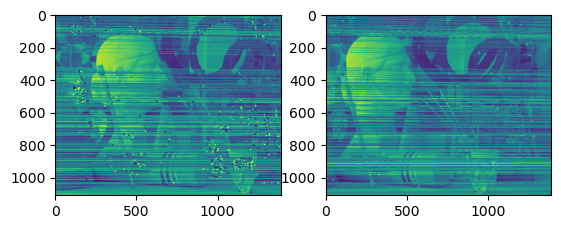

In [9]:
good_pts_left_art,good_pts_right_art,F_art=ptForEplilines(left_art,right_art,good_pts_left_art,good_pts_right_art)

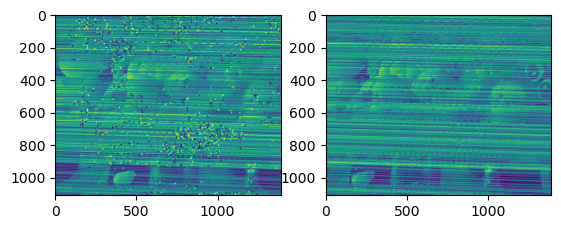

In [10]:
good_pts_left_doll,good_pts_right_doll,F_doll=ptForEplilines(left_doll,right_doll,good_pts_left_doll,good_pts_right_doll)


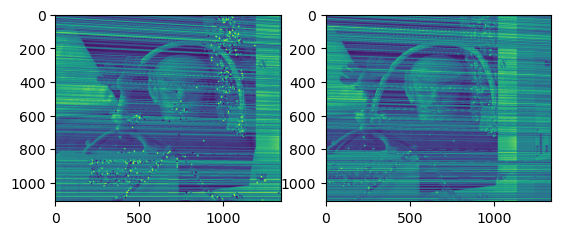

In [11]:
good_pts_left_reindeer,good_pts_right_reindeer,F_reindeer=ptForEplilines(left_reindeer,right_reindeer,good_pts_left_reindeer,good_pts_right_reindeer)

<h3>Step 4 : Rectify image using fundamental matrix, points for epiplines</h3>


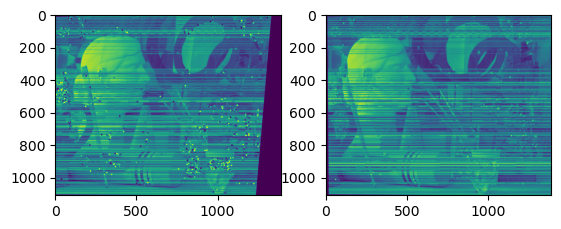

In [12]:
left_rect_art,right_rect_art=rectImage(left_art,right_art,good_pts_left_art,good_pts_right_art,F_art)



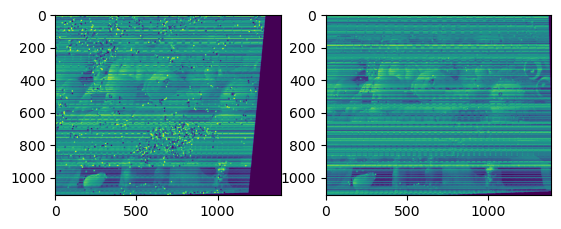

In [13]:
left_rect_doll,right_rect_doll=rectImage(left_doll,right_doll,good_pts_left_doll,good_pts_right_doll,F_doll)

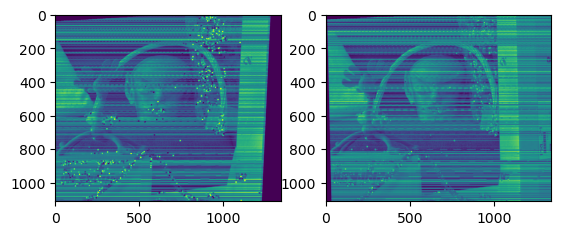

In [14]:
left_rect_reindeer,right_rect_reindeer=rectImage(left_reindeer,right_reindeer,good_pts_left_reindeer,good_pts_right_reindeer,F_reindeer)

<h3>Step 5: Calculating Disparity Map Using Stereo SGBM</h3>


The PSNR score is 9.978076885106368


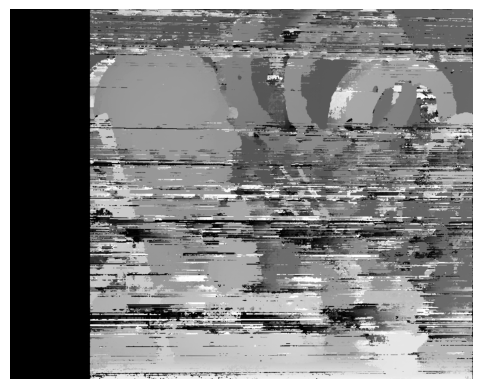

In [180]:
blockSize=1
stereo = cv2.StereoSGBM_create(minDisparity=0,
                                numDisparities=16*15,
                                blockSize=blockSize,
                                P1=8 * 3 * blockSize * blockSize,#3mig channel
                                P2=32 * 3 * blockSize* blockSize ,#3mig channel
                                disp12MaxDiff=10000,
                                uniquenessRatio=0,
                                speckleWindowSize=0,
                                speckleRange=32
                        
                                ) 

disparity = stereo.compute(left_rect_art, right_rect_art)
disparity_norm_art = cv2.normalize(disparity, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
cv2.imwrite('disparity_norm_art.png', disparity_norm_art)
calculate_psnr(disparity_norm_art,truth_art)
plt.imshow(disparity_norm_art,'gray' )
plt.axis('off')
plt.show()

The PSNR score is 9.71982039668587


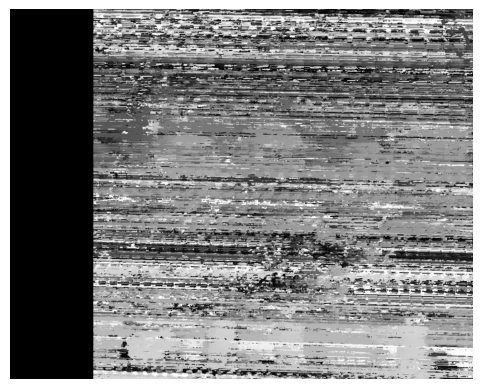

In [181]:
blockSize=1
stereo = cv2.StereoSGBM_create(minDisparity=10,
                                numDisparities=16*15,
                                blockSize=blockSize,
                                P1=8 * 3 * blockSize * blockSize,#3mig channel
                                P2=32 * 3 * blockSize* blockSize ,#3mig channel
                                disp12MaxDiff=150,
                                uniquenessRatio=0,
                                speckleWindowSize=0,
                                speckleRange=100
                        
                                )


disparity = stereo.compute(left_rect_doll, right_rect_doll)
disparity_norm_doll = cv2.normalize(disparity, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
cv2.imwrite('disparity_norm_doll.png', disparity_norm_doll)
calculate_psnr(disparity_norm_doll,truth_doll)
plt.imshow(disparity_norm_doll,'gray' )
plt.axis('off')
plt.show()

The PSNR score is 10.273656127222289


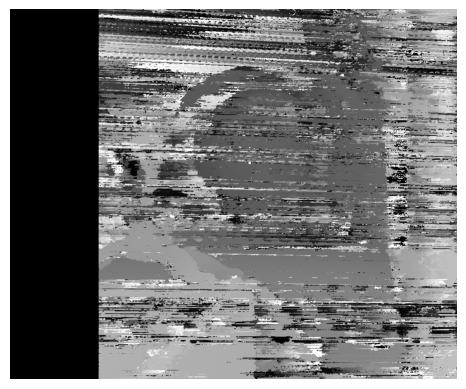

In [182]:
blockSize=1
stereo = cv2.StereoSGBM_create(minDisparity=10,
                                numDisparities=16*16,
                                blockSize=blockSize,
                                P1=8 * 3 * blockSize * blockSize,#3mig channel
                                P2=32 * 3 * blockSize* blockSize ,#3mig channel
                                disp12MaxDiff=100,
                                uniquenessRatio=0,
                                speckleWindowSize=0,
                                speckleRange=100
                                )


disparity = stereo.compute(left_rect_reindeer, right_rect_reindeer)
disparity_norm_reindeer = cv2.normalize(disparity, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
cv2.imwrite('disparity_norm_reindeer.png', disparity_norm_reindeer)
calculate_psnr(disparity_norm_reindeer,truth_reindeer)
plt.imshow(disparity_norm_reindeer,'gray' )
plt.axis('off')
plt.show()

<h3>Step 6: Postprocessing with inpainting technique and filtering </h3>

The PSNR score is 14.524497373027756


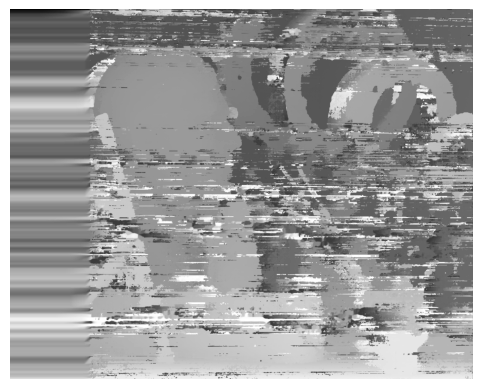

The PSNR score is 16.067496360084522


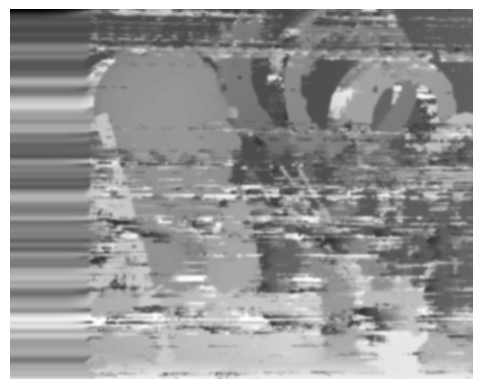

In [183]:
mask=np.zeros_like(disparity_norm_art)
mask[disparity_norm_art<60]=255
disparity_inpaint_art=cv2.inpaint(disparity_norm_art,mask,2,cv2.INPAINT_NS)

calculate_psnr(disparity_inpaint_art,truth_art)
cv2.imwrite('disparity_inpaint_art.png', disparity_inpaint_art)
plt.imshow(disparity_inpaint_art ,'gray')
plt.axis('off')
plt.show()

disparity_filter_art =  cv2.GaussianBlur(disparity_inpaint_art, (21,21), 0)
calculate_psnr(disparity_filter_art,truth_art)
cv2.imwrite('disparity_inpaint_filter_art.png', disparity_filter_art)
plt.imshow(disparity_filter_art ,'gray')
plt.axis('off')
plt.show()

12.972969340432334


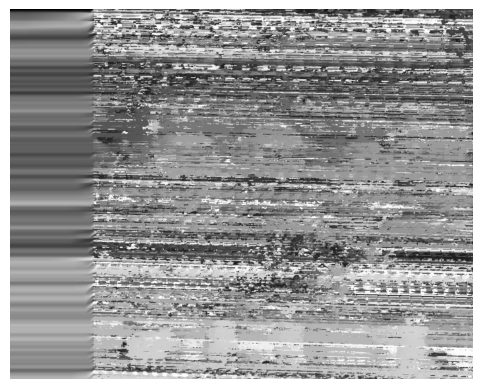

15.527950938304162


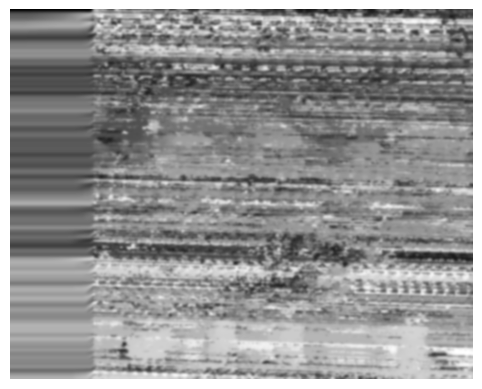

In [175]:
mask=np.zeros_like(disparity_norm_doll)
mask[disparity_norm_doll<30]=255
disparity_inpaint_doll=cv2.inpaint(disparity_norm_doll,mask,2,cv2.INPAINT_NS)

calculate_psnr(disparity_inpaint_doll,truth_doll)
cv2.imwrite('disparity_inpaint_doll.png', disparity_inpaint_doll)
plt.imshow(disparity_inpaint_doll ,'gray')
plt.axis('off')
plt.show()

disparity_filter_doll =  cv2.GaussianBlur(disparity_inpaint_doll, (21,21), 0)
calculate_psnr(disparity_filter_doll,truth_doll)
cv2.imwrite('disparity_inpaint_filter_doll.png', disparity_filter_doll)
plt.imshow(disparity_filter_doll ,'gray')
plt.axis('off')
plt.show()

13.253934837408778


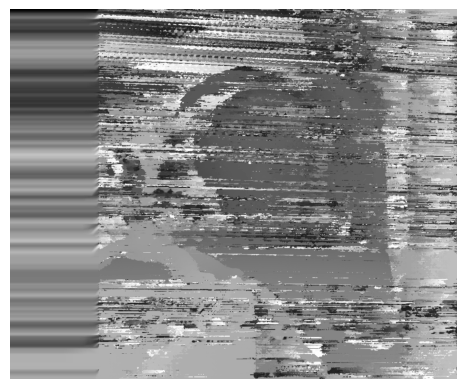

14.934954560511962


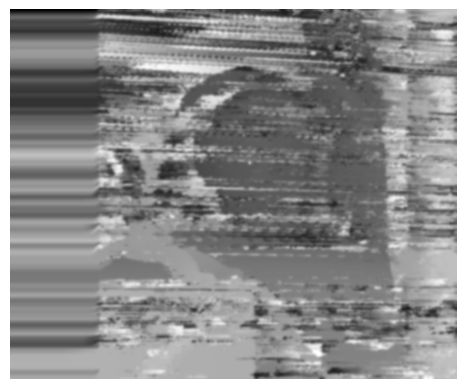

In [176]:
mask=np.zeros_like(disparity_norm_reindeer)
mask[disparity_norm_reindeer<30]=255
disparity_inpaint_reindeer=cv2.inpaint(disparity_norm_reindeer,mask,2,cv2.INPAINT_NS)

calculate_psnr(disparity_inpaint_reindeer,truth_reindeer)
cv2.imwrite('disparity_inpaint_reindeer.png', disparity_inpaint_reindeer)
plt.imshow(disparity_inpaint_reindeer ,'gray')
plt.axis('off')
plt.show()

disparity_filter_reindeer =  cv2.GaussianBlur(disparity_inpaint_reindeer, (21,21), 0)
calculate_psnr(disparity_filter_reindeer,truth_reindeer)
cv2.imwrite('disparity_inpaint_filter_reindeer.png', disparity_filter_reindeer)
plt.imshow(disparity_filter_reindeer ,'gray')
plt.axis('off')
plt.show()